# Implementación en Python del modelo epidemiológico COVID-19 de CDMX

[Modelo publicado por el gobierno de la Ciudad de México](https://modelo.covid19.cdmx.gob.mx/modelo-epidemico)

Robado de la implementación original en Julia de [@ollin18](https://github.com/ollin18/ComplexSystems.jl/blob/master/examples/CDMX_model.ipynb)

Este notebook es una versión simplificada de [mi reimplementación](CDMX_py.ipynb) del [original](https://github.com/ollin18/ComplexSystems.jl/blob/master/examples/CDMX_model.ipynb).

Esta versión es únicamente el modelo determinístico sin consideraciones de variablidad.

Implementa la posibilidad de aplicar intervenciones como las especificadas en el sitio de CDMX.

![ecuaciones.png](img/ecuaciones.png)

Donde:

- S = Susceptibles
- E = Expuestos
- I = Infectados
- L = Contagiados sintomáticos leves
- G = Contagiados sintomáticos graves
- H = Hospitalizados
- ICU = Unidad de Terapia Intensiva
- R = Recuperados
- M = Muertos

![modelo](img/variables.png)

Los parámetros del modelo pueden ser consultados en la página del modelo o en el [archivo que he respaldado](cdmx_archive) por si hay cambios mas adelante. En la implementación del modelo se puede ver los usados en este caso y a qué corresponden.

In [1]:
#https://modelo.covid19.cdmx.gob.mx/modelo-epidemico
#https://github.com/ollin18/ComplexSystems.jl/blob/master/examples/CDMX_model.ipynb

from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint

sns.set(style="whitegrid")

VARS = ['susceptibles', 'infecciosos', 'expuestos', 'leve', 
        'grave', 'hospitalizados', 'uci', 'recuperados', 'muertos']

In [2]:
FMT = "%Y-%m-%d"
#FECHA_INICIO = '2020-02-17' #CDMX - 4 casos
FECHA_INICIO = '2020-03-13' #Querétaro - 4 casos
FECHA_FINAL = '2020-12-31'
POBLACION = 2300000 #Zona metro Querétaro https://www.eluniversalqueretaro.mx/metropoli/poblacion-de-la-metropoli-crecio-16-en-nueve-anos
#POBLACION = 22000000 #CDMX según modelo
MULTIPLICADOR_SUBREPORTE = 2
INFECCION_INICIAL = MULTIPLICADOR_SUBREPORTE * 4 / POBLACION # Prob(inf) inicial, 4 confirmados en esa fecha, revisar del modelo CDMX

MODELAR_INTERVENCIONES = True

#Interveciones según modelo CDMX (1)
#intervenciones_fechas = ['2020-03-22', '2020-03-31']
#intervenciones_R0 = [2.2, 0.95]

#Interveciones según modelo CDMX (2), ajustados al 25 de abril, optimista
#intervenciones_fechas = ['2020-03-22', '2020-04-01', '2020-04-13', '2020-04-20']
#intervenciones_R0 = [2.2, 0.95, 1.2, 0.95]

#Mis intervenciones What-if?
#intervenciones_fechas = ['2020-03-22', '2020-04-01', '2020-04-13', '2020-04-20', '2020-07-01', '2020-08-15']
#intervenciones_R0 = [2.2, 0.95, 1.2, 0.95, 1.2, 0.95]

#Mis intervenciones Querétaro
intervenciones_fechas = [FECHA_INICIO, '2020-03-22', '2020-04-01', '2020-04-13', '2020-04-20']
intervenciones_R0 = [2, 1.2, 1.2, 1.2, 0.99]

## Implementación

Esta es la función que implementa el modelo. Su firma debe ser compatible con la firma que espera [`scipy.integrate.odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) (ordinary diferential equations).

- En `x` se recibe el vector de variables
- En `t` es el paso de tiempo que se está ejecutando (en este caso el modelo no cambia en el tiempo)

El modelo regresa un arreglo en el mismo formato con el resultado de aplicar las funciones a los K_max ejemplos para el tiempo t.

In [3]:
def CDMX(x, t):
    def iof(ind):
        """IndexOF: solo sirve para sacar el arreglo de la variable de interés"""
        n = VARS.index(ind)
        return x[n]    

    #Nombres en el modelo de CDMX (2020-05-14)
    R0=2.83291         #Tasa de reproducción estimada, act. 20200515 descrito en "Proyecciones"
    Dinf=2.9        #Tiempo que es infeccioso el paciente
    Dincub=5.2      #Tiempo incubación
    Drl=14          #Tiempo recuperación casos intermedios
    Dhosp=4         #Días entre síntomas y hospitalización
    Drh=12          #Días totales de hospitalización
    Duci=1          #**No especificado en modelo: Dias en UCI
    Druci=7 #10     #**No especificado en modelo: Dias de recuperacion de UCI
    Dm=8            #**No especificado en modelo: Dias a muerte en UCI
    pgrav=0.138     #Tasa de hospitalización
    puci=0.05       #Tasa de UCI
    pm=0.65        #Tasa de mortalidad. 0.03, sin embargo se ha cuestionado si debe ser 0.65
    #Otros:
    #  Tiempo entre incubación y muerte [dias]: 32 
    #  Poblacion susceptible [millones]: 22 (ver en código)

    if MODELAR_INTERVENCIONES:
        inicio = datetime.strptime(FECHA_INICIO, FMT)
        dt_actual = inicio + timedelta(days=int(t))
        for index, fecha_interv in enumerate(intervenciones_fechas):
            if dt_actual >= datetime.strptime(fecha_interv, FMT):
                R0 = intervenciones_R0[index]
        #print(R0)
                
    y = np.zeros(len(x))

    d_sus = -(R0/Dinf) * iof('infecciosos') * iof('susceptibles')
    d_exp = (R0/Dinf) * iof('infecciosos') * iof('susceptibles') - (1/Dincub)*iof('expuestos')
    d_inf = (1/Dincub) * iof('expuestos') - (1/Dinf) * iof('infecciosos')
    d_leve = (1-pgrav) * (1/Dinf) * iof('infecciosos') - (1/Drl) * iof('leve')
    d_grav = pgrav * (1/Dinf) * iof('infecciosos') - (1/Dhosp) * iof('grave')
    d_hosp = (1/Dhosp) * iof('grave') - (1-puci) * (1/Drh) * iof('hospitalizados') \
        - puci * (1/Duci)*iof('hospitalizados')
    d_uci = puci * (1/Duci) * iof('hospitalizados') - (1-pm) * (1/Druci) * iof('uci') \
        - pm * (1/Dm) * iof('uci')
    d_rec = (1/Drl) * iof('leve') + (1-puci) * (1/Drh) * iof('hospitalizados') \
        + (1-pm) * (1/Druci) * iof('uci')
    d_mue = pm * (1/Dm) * iof('uci')

    y[0] = d_sus
    y[1] = d_inf
    y[2] = d_exp
    y[3] = d_leve
    y[4] = d_grav
    y[5] = d_hosp
    y[6] = d_uci
    y[7] = d_rec
    y[8] = d_mue
            
    return y

### Ejecución del modelo

Inicialización de la matriz de variables

In [4]:
init = [(1 - INFECCION_INICIAL), INFECCION_INICIAL, 0, 0, 0, 0, 0, 0, 0]

Ejecución del modelo, resuelve el sistema de ecuaciones diferenciales en los tiempos definidos en `t` (días)

In [5]:
inicial = datetime.strptime(FECHA_INICIO, FMT)
dias_por_modelar = (datetime.strptime(FECHA_FINAL, FMT) - inicial).days
t = np.arange(0, dias_por_modelar, 1)
t_labels = [(inicial+timedelta(days=int(d))).strftime(FMT) for d in t]

In [6]:
y1 = odeint(CDMX, init, t)

In [7]:
y1.shape

(293, 9)

In [8]:
#Un paso en el tiempo, día 2
print(y1[2].shape)
y1[2]

(9,)


array([9.99992776e-01, 2.28490095e-06, 3.06638484e-06, 1.49672630e-06,
       1.99713871e-07, 5.36724263e-08, 1.83591646e-09, 1.21012311e-07,
       8.41401128e-11])

Los resultados se obtienen tras sumar los de cada ejemplo

In [9]:
res = {}
for index, var in enumerate(VARS):
    res[var] = [ye[index] for ye in y1]
#res

## Resultados
### Suceptibles,  Expuestos, Infectados y Recuperados como proporción de la población

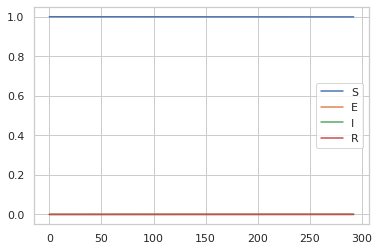

In [10]:
plt.plot(t, res['susceptibles'], label="S", )
plt.plot(t, res['expuestos'], label="E")
plt.plot(t, res['infecciosos'], label="I")
plt.plot(t, res['recuperados'], label="R")
plt.legend()

### Evolución de los enfermos, totales por población

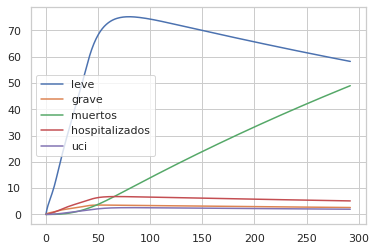

In [11]:
for var in ['leve', 'grave', 'muertos', 'hospitalizados', 'uci']:
    plt.plot(t, np.multiply(res[var], POBLACION), label=var)
    #plt.yscale('log')
plt.legend()

### Uso máximo de UCI

In [12]:
max(res["uci"]) * POBLACION

2.568406397646138

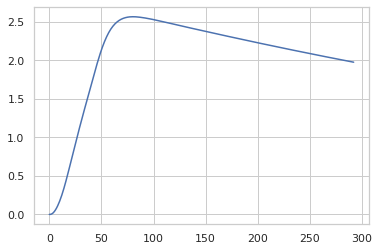

In [13]:
uci = np.multiply(res["uci"], POBLACION)
plt.plot(uci)

In [14]:
from covid_analysis import *
estados = load_mariorz()

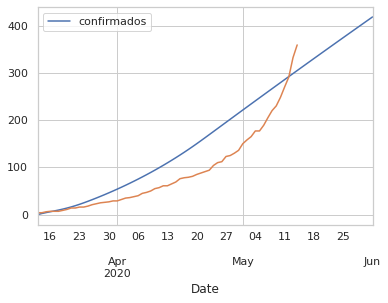

In [15]:
import pandas as pd
confirmados = np.array([res['leve'], res['grave'], res['uci'], res['hospitalizados'], res['muertos'], res['recuperados']])
confirmados = np.multiply(np.sum(confirmados, axis=0), POBLACION)
d = pd.DataFrame({'fecha':t_labels, 'confirmados':confirmados})
#d['fecha'] = pd.to_datetime(d['fecha']).dt.date
d = d.set_index('fecha')
d.index = pd.to_datetime(d.index)
d[:'2020-06-01'].plot()
estados['confirmados']['Queretaro'][FECHA_INICIO:].plot()

## Pruebas